In [28]:
import pandas as pd
import matplotlib.cm as cm
import matplotlib.colors as colors
import requests
import numpy as np
# import k-means from clustering stage
from sklearn.cluster import KMeans
from bs4 import BeautifulSoup

import folium # map rendering library #!pip install folium
%matplotlib inline

## Q1: Data preprocessing

In [29]:
# Data in Wiki has changed; Have to use an older verion to recieve old version of the data
source = requests.get\
    (\
    'https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&oldid=862527922'\
    ).text

In [30]:
# Extracted Data from Wiki
postal_code=BeautifulSoup(source,'lxml')
df=pd.read_html(str(postal_code.table))[0][1:]
# Dataframe columns: PostalCode, Borough, and Neighborhood
df.columns=['Postal Code', 'Borough','Neighbourhood']

In [31]:
df.head(15)

,Postal Code,Borough,Neighbourhood
1,M1A,Not assigned,Not assigned
2,M2A,Not assigned,Not assigned
3,M3A,North York,Parkwoods
4,M4A,North York,Victoria Village
5,M5A,Downtown Toronto,Harbourfront
6,M5A,Downtown Toronto,Regent Park
7,M6A,North York,Lawrence Heights
8,M6A,North York,Lawrence Manor
9,M7A,Queen's Park,Not assigned
10,M8A,Not assigned,Not assigned


In [32]:
# 1. Only process the cells that have an assigned borough.
idx=df[df['Borough']=="Not assigned"].index
df.drop(idx, axis=0, inplace=True)

In [33]:
# 2. More than one neighborhood can exist in one postal code area
# Combine into one column
tor=df.groupby(['Postal Code', 'Borough'], sort = False).agg( ', '.join).reset_index()
tor.head(15)

,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Harbourfront, Regent Park"
3,M6A,North York,"Lawrence Heights, Lawrence Manor"
4,M7A,Queen's Park,Not assigned
5,M9A,Etobicoke,Islington Avenue
6,M1B,Scarborough,"Rouge, Malvern"
7,M3B,North York,Don Mills North
8,M4B,East York,"Woodbine Gardens, Parkview Hill"
9,M5B,Downtown Toronto,"Ryerson, Garden District"


In [34]:
# 3. If a cell has a borough but a Not assigned neighborhood, 
# then the neighborhood will be the same as the borough.
tor.loc[tor['Neighbourhood'] == 'Not assigned','Neighbourhood']=tor['Borough']

In [35]:
# 4. Shape of data frame
tor.shape

(103, 3)

## Q2: Merge two datasets

In [36]:
# 1. Importing the csv file 
lat_lon = pd.read_csv('https://cocl.us/Geospatial_data')
lat_lon.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [46]:
# 2. Merge two datasets
df_toronto = pd.merge(tor, lat_lon, on = 'Postal Code')
df_toronto.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.654260,-79.360636
3,M6A,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763
4,M7A,Queen's Park,Queen's Park,43.662301,-79.389494


## Q3: K-means

In [47]:
# Cluster Neighborhoods
k=5
tor_kmean = df_toronto.drop(['Postal Code','Borough','Neighbourhood'],1)
kmeans = KMeans(n_clusters = k,random_state=0).fit(tor_kmean)
kmeans.labels_

array([4, 4, 2, 3, 2, 1, 0, 4, 4, 2, 3, 1, 0, 4, 4, 2, 2, 1, 0, 4, 2, 2, 0,
       4, 2, 2, 0, 3, 3, 4, 2, 2, 0, 3, 3, 4, 2, 2, 0, 3, 3, 4, 2, 2, 4, 3,
       1, 4, 2, 1, 1, 0, 3, 1, 4, 3, 1, 1, 4, 3, 1, 3, 3, 1, 1, 0, 3, 3, 2,
       1, 1, 0, 3, 3, 2, 2, 1, 1, 0, 2, 2, 1, 0, 2, 2, 0, 2, 2, 1, 1, 0, 2,
       2, 1, 1, 0, 2, 2, 1, 2, 4, 1, 1], dtype=int32)

In [48]:
# add clustering labels
df_toronto.insert(0, 'Cluster Labels', kmeans.labels_)

In [49]:
# create map
map_clusters = folium.Map(location=[43.651070,-79.347015],zoom_start=10)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, neighbourhood, cluster in zip(df_toronto['Latitude'], df_toronto['Longitude'], \
                                            df_toronto['Neighbourhood'], df_toronto['Cluster Labels']):
    label = folium.Popup(' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

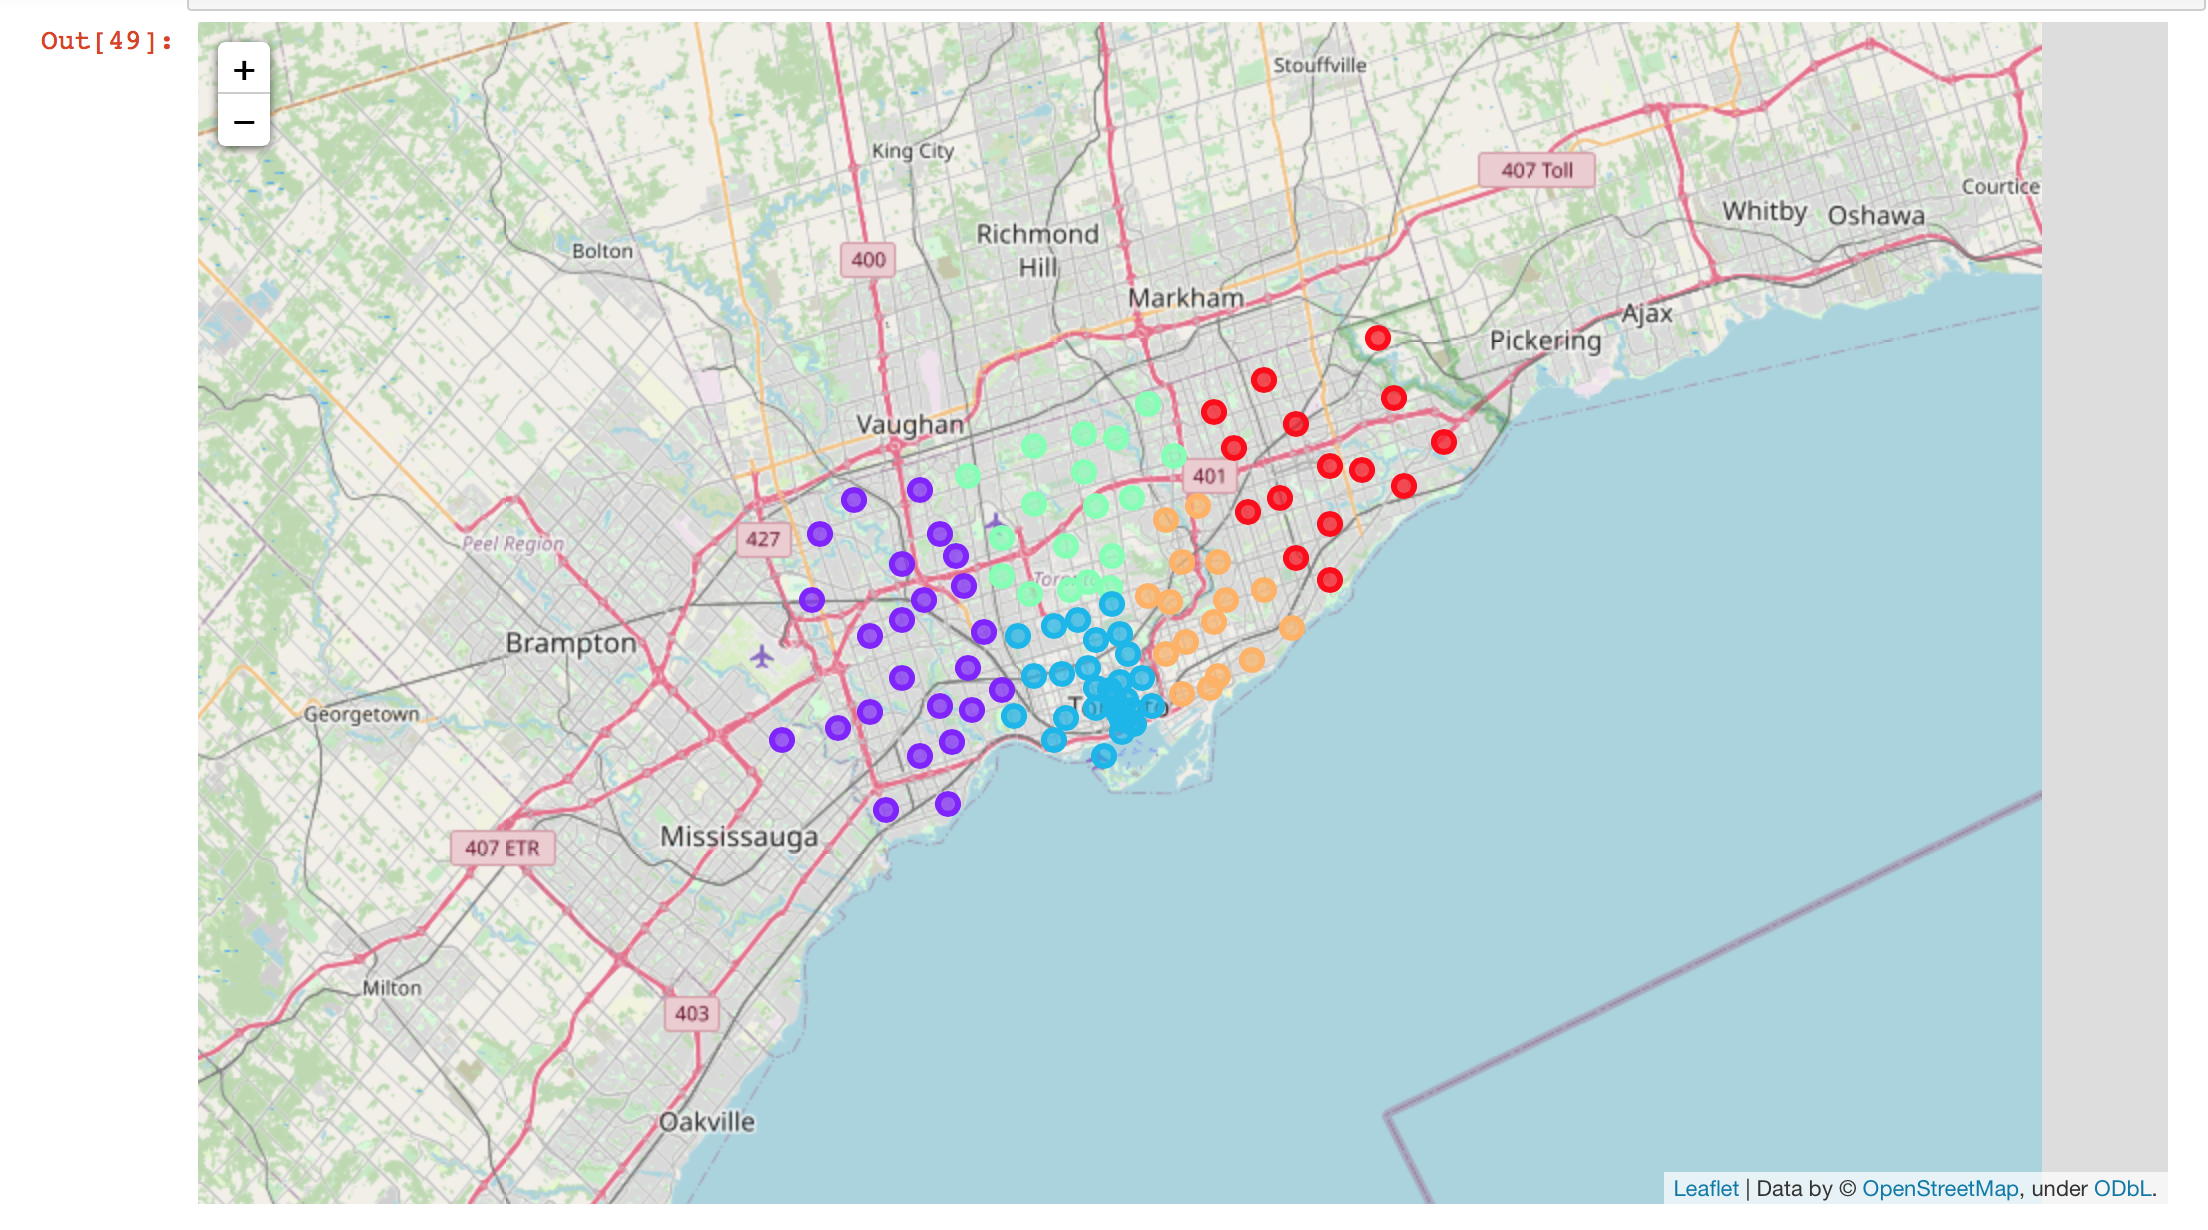

In [51]:
# Taking screenshot from output above as Git cann't display folium output properly
from IPython.display import Image
Image(filename='~/Screenshot_Output49.png') 

Without other features (eg. venues) introduced, the neigbourhood segments are evenly distributed based on location (latitude and longtitude). However, we can expect more complicated patterns once other varieties are added.